# Imports

In [0]:
import os

base_dir = "/content/gdrive/My Drive/Masterarbeit"
object_detection_dir = os.path.join(base_dir, "ObjectDetection")

In [0]:
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

1.13.1
Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!git clone https://github.com/tensorflow/models.git /content/tf
!cd /content/tf/research; protoc object_detection/protos/*.proto --python_out=.
!cd /content/tf/research; export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim; python /content/tf/research/object_detection/builders/model_builder_test.py

Cloning into '/content/tf'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 25626 (delta 1), reused 3 (delta 1), pack-reused 25618
Receiving objects: 100% (25626/25626), 508.01 MiB | 39.77 MiB/s, done.
Resolving deltas: 100% (15371/15371), done.
Checking out files: 100% (2882/2882), done.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.056s

OK (skipped=1)


In [0]:
import sys
sys.path.append('tf/research')
sys.path.append('tf/research/slim')

# Create Dataset

In [0]:
import os
import shutil

#copy all images unknown from a folder to a prediction folder
sub_folder = os.path.join(object_detection_dir,"Images","smart_phone","_Automat")
predict_folder = os.path.join(object_detection_dir,"predict_folder")
with open(os.path.join(predict_folder,"path.txt"), "w+") as file:
  file.write(sub_folder)

file_list = os.listdir(sub_folder)
for file in file_list:
  if (file.endswith(".png") or file.endswith(".jpg") and
      not ".".join(file.split(".")[:-1] + ["xml"]) in file_list):
    shutil.copy(os.path.join(sub_folder, file),
                os.path.join(predict_folder, file))

In [0]:
sys.path.append('tf/research')
sys.path.append('tf/research/slim')
from object_detection.utils import dataset_util

def create_tf_example(img_width, img_height, img_filename, img_encoded_data,
                      img_format):
  """Creates a tf example for the data
  Args:
    img_height: image height in pxl
    img_width: image widht in pxl
    img_filename: filename of the image
    img_encoded_data: encoded image bytes
  Returns:
    tf_example: a tf example for the Record Writer
  """

  
  feature_dict = {
      'image/height': dataset_util.int64_feature(img_height),
      'image/width': dataset_util.int64_feature(img_width),
      'image/filename': dataset_util.bytes_feature(img_filename.encode('utf-8')),
      'image/source_id': dataset_util.bytes_feature(img_filename.encode('utf-8')),
      'image/encoded': dataset_util.bytes_feature(img_encoded_data),
      'image/format': dataset_util.bytes_feature(img_format.encode('utf-8')),
  }
  tf_example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return tf_example

In [0]:
import numpy as np
import cv2

def resize_to_ratio(image, max_length = 1024, padded=False):
  """resize the image to max_length along longest side
  and keep the ratio for the other side.
  Args:
    image: the image as numpy array
    max_length: max length in pixel along longest side
  Returns:
    the resized image
  """
  height_old, width_old, channels = image.shape
  if width_old > height_old:
    scaler = width_old / max_length
  else:
    scaler = height_old / max_length
  
  height = int(height_old / scaler) 
  width = int(width_old / scaler)
  
  image = cv2.resize(image, (width,height))
  
  if padded:
    pad_x = 0
    pad_y = 0
    if height < max_length:
      pad_size = max_length - height
      pad_x = int(pad_size/2)
    if width < max_length:
      pad_size = max_length - width
      pad_y = int(pad_size/2)
    
    image_old = image
    image = np.zeros([max_length, max_length, 3])
    image[pad_x:(pad_x + height), pad_y:(pad_y + width), :] = image_old
    
    width = max_length
    height = max_length
    
  return image, height, width

In [0]:
import cv2
from matplotlib.pyplot import imshow

def create_tfr_from_folder(folder, record_file, resolution, padded):
  tfr_writer = tf.python_io.TFRecordWriter(record_file)
  
  file_list = os.listdir(folder)
  for file in file_list:
    if file.endswith(".jpg"):
      file_ending = ".jpg"
    elif file.endswith(".png"):
      file_ending = ".png"
    else:
      continue
      
    print("working on: ", file)
    img_file = os.path.join(folder, file)
    image = cv2.imread(img_file, 1)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image, height, width = resize_to_ratio(image, resolution, padded)
    #M = cv2.getRotationMatrix2D((width / 2, height / 2), 270, 1.0)
    #image = cv2.warpAffine(image, M, (height, width))

    cv2.imwrite("tmp"+file_ending, image)

    with tf.gfile.Open("tmp"+file_ending, "rb") as file:
      encoded_img = file.read()

    tf_example = create_tf_example(width,
                                   height,
                                   img_file,
                                   encoded_img,
                                   file_ending)
    tfr_writer.write(tf_example.SerializeToString())

In [0]:
import os
predict_folder = os.path.join(object_detection_dir,"predict_folder")

create_tfr_from_folder(predict_folder,
                       os.path.join(predict_folder, "predict.record"),
                       640,
                       True)

working on:  IMG_20181218_171753.jpg
working on:  IMG_20181218_171749.jpg
working on:  IMG_20181218_171743.jpg
working on:  IMG_20181218_171740.jpg
working on:  IMG_20181218_171607.jpg
working on:  IMG_20181218_171601.jpg
working on:  IMG_20181218_171557.jpg
working on:  IMG_20181218_171555.jpg
working on:  IMG_20181218_170657.jpg
working on:  IMG_20181218_170655.jpg
working on:  IMG_20181218_174601.jpg
working on:  IMG_20190125_113825 (1).jpg
working on:  IMG_20190125_113823 (1).jpg
working on:  IMG_20190125_113830 (1).jpg
working on:  IMG_20190125_113835 (1).jpg
working on:  IMG_20190125_134005 (1).jpg
working on:  IMG_20190125_134001 (1).jpg
working on:  IMG_20190125_133951 (1).jpg
working on:  IMG_20190125_133958 (1).jpg
working on:  IMG_20190206_115008_01.jpg
working on:  IMG_20181218_172432.jpg
working on:  IMG_20181218_172433.jpg
working on:  IMG_20181218_172436.jpg
working on:  IMG_20181218_172438.jpg
working on:  IMG_20181218_172442.jpg
working on:  IMG_20181218_172839.jpg
wor

dict_keys(['image/source_id', 'image/encoded', 'image/width', 'image/filename', 'image/format', 'image/height'])
/content/gdrive/My Drive/Masterarbeit/ObjectDetection/predict_folder/IMG_20181218_171753.jpg
[640]
[640]
(640, 640)


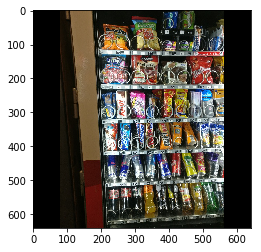

In [0]:
%matplotlib inline
#import IPython.display as display
import io
import tensorflow as tf
import PIL
from matplotlib.pyplot import imshow
import numpy as np

record_iterator = tf.python_io.tf_record_iterator(path=os.path.join(object_detection_dir,
                                                                    "predict_folder",
                                                                    "predict.record"))

for string_record in record_iterator:
  example = tf.train.Example()
  example.ParseFromString(string_record)

  print(dict(example.features.feature).keys())
  print(example.features.feature["image/filename"].bytes_list.value[0].decode('utf-8'))
  print(example.features.feature["image/height"].int64_list.value)
  print(example.features.feature["image/width"].int64_list.value)
  #print(type(example.features.feature["image/encoded"].bytes_list.value))
  encoded_jpg_io = io.BytesIO(example.features.feature["image/encoded"].bytes_list.value[0])
  pil_image = PIL.Image.open(encoded_jpg_io)
  print(pil_image.size)
  image = np.asarray(pil_image)
  imshow(image)
  
  break

# Inference

In [0]:
import time
import itertools
import tensorflow as tf
from object_detection.inference import detection_inference

tf.flags.DEFINE_string('input_tfrecord_paths', None,
                       'A comma separated list of paths to input TFRecords.')
tf.flags.DEFINE_string('output_tfrecord_path', None,
                       'Path to the output TFRecord.')
tf.flags.DEFINE_string('inference_graph', None,
                       'Path to the inference graph with embedded weights.')
tf.flags.DEFINE_boolean('discard_image_pixels', False,
                        'Discards the images in the output TFExamples. This'
                        ' significantly reduces the output size and is useful'
                        ' if the subsequent tools don\'t need access to the'
                        ' images (e.g. when computing evaluation measures).')

FLAGS = tf.flags.FLAGS

In [0]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Utility functions for detection inference."""
from __future__ import division

import tensorflow as tf

from object_detection.core import standard_fields


def build_input(tfrecord_paths):
  """Builds the graph's input.
  Args:
    tfrecord_paths: List of paths to the input TFRecords
  Returns:
    serialized_example_tensor: The next serialized example. String scalar Tensor
    image_tensor: The decoded image of the example. Uint8 tensor,
        shape=[1, None, None,3]
  """
  filename_queue = tf.train.string_input_producer(
      tfrecord_paths, shuffle=False, num_epochs=1)

  tf_record_reader = tf.TFRecordReader()
  _, serialized_example_tensor = tf_record_reader.read(filename_queue)
  features = tf.parse_single_example(
      serialized_example_tensor,
      features={
          standard_fields.TfExampleFields.image_encoded:
              tf.FixedLenFeature([], tf.string),
      })
  encoded_image = features[standard_fields.TfExampleFields.image_encoded]
  image_tensor = tf.image.decode_image(encoded_image, channels=3)
  image_tensor.set_shape([None, None, 3])
  image_tensor = tf.expand_dims(image_tensor, 0)

  return serialized_example_tensor, image_tensor


def build_inference_graph(image_tensor, inference_graph_path):
  """Loads the inference graph and connects it to the input image.
  Args:
    image_tensor: The input image. uint8 tensor, shape=[1, None, None, 3]
    inference_graph_path: Path to the inference graph with embedded weights
  Returns:
    detected_boxes_tensor: Detected boxes. Float tensor,
        shape=[num_detections, 4]
    detected_scores_tensor: Detected scores. Float tensor,
        shape=[num_detections]
    detected_labels_tensor: Detected labels. Int64 tensor,
        shape=[num_detections]
  """
  with tf.gfile.Open(inference_graph_path, 'rb') as graph_def_file:
    graph_content = graph_def_file.read()
  graph_def = tf.GraphDef()
  graph_def.MergeFromString(graph_content)

  tf.import_graph_def(
      graph_def, name='', input_map={'image_tensor': image_tensor})

  g = tf.get_default_graph()

  num_detections_tensor = tf.squeeze(
      g.get_tensor_by_name('num_detections:0'), 0)
  num_detections_tensor = tf.cast(num_detections_tensor, tf.int32)

  detected_boxes_tensor = tf.squeeze(
      g.get_tensor_by_name('detection_boxes:0'), 0)
  detected_boxes_tensor = detected_boxes_tensor[:num_detections_tensor]

  detected_scores_tensor = tf.squeeze(
      g.get_tensor_by_name('detection_scores:0'), 0)
  detected_scores_tensor = detected_scores_tensor[:num_detections_tensor]

  detected_labels_tensor = tf.squeeze(
      g.get_tensor_by_name('detection_classes:0'), 0)
  detected_labels_tensor = tf.cast(detected_labels_tensor, tf.int64)
  detected_labels_tensor = detected_labels_tensor[:num_detections_tensor]

  return detected_boxes_tensor, detected_scores_tensor, detected_labels_tensor


def infer_detections_and_add_to_example(
    serialized_example_tensor, detected_boxes_tensor, detected_scores_tensor,
    detected_labels_tensor, discard_image_pixels):
  """Runs the supplied tensors and adds the inferred detections to the example.
  Args:
    serialized_example_tensor: Serialized TF example. Scalar string tensor
    detected_boxes_tensor: Detected boxes. Float tensor,
        shape=[num_detections, 4]
    detected_scores_tensor: Detected scores. Float tensor,
        shape=[num_detections]
    detected_labels_tensor: Detected labels. Int64 tensor,
        shape=[num_detections]
    discard_image_pixels: If true, discards the image from the result
  Returns:
    The de-serialized TF example augmented with the inferred detections.
  """
  tf_example = tf.train.Example()
  (serialized_example, detected_boxes, detected_scores,
   detected_classes) = tf.get_default_session().run([
       serialized_example_tensor, detected_boxes_tensor, detected_scores_tensor,
       detected_labels_tensor
   ])
  detected_boxes = detected_boxes.T

  print(detected_scores)
  print(detected_classes)
  print(detected_boxes)
  
  tf_example.ParseFromString(serialized_example)
  feature = tf_example.features.feature
  feature[standard_fields.TfExampleFields.
          detection_score].float_list.value[:] = detected_scores
  feature[standard_fields.TfExampleFields.
          detection_bbox_ymin].float_list.value[:] = detected_boxes[0]
  feature[standard_fields.TfExampleFields.
          detection_bbox_xmin].float_list.value[:] = detected_boxes[1]
  feature[standard_fields.TfExampleFields.
          detection_bbox_ymax].float_list.value[:] = detected_boxes[2]
  feature[standard_fields.TfExampleFields.
          detection_bbox_xmax].float_list.value[:] = detected_boxes[3]
  feature[standard_fields.TfExampleFields.
          detection_class_label].int64_list.value[:] = detected_classes

  if discard_image_pixels:
    del feature[standard_fields.TfExampleFields.image_encoded]

  return tf_example

In [0]:
def main(_):
  tf.logging.set_verbosity(tf.logging.INFO)

  required_flags = ['input_tfrecord_paths', 'output_tfrecord_path',
                    'inference_graph']
  for flag_name in required_flags:
    if not getattr(FLAGS, flag_name):
      raise ValueError('Flag --{} is required'.format(flag_name))

  with tf.Session() as sess:
    input_tfrecord_paths = [
        v for v in FLAGS.input_tfrecord_paths.split(',') if v]
    tf.logging.info('Reading input from %d files', len(input_tfrecord_paths))
    serialized_example_tensor, image_tensor = build_input(
        input_tfrecord_paths)
    tf.logging.info('Reading graph and building model...')
    (detected_boxes_tensor, detected_scores_tensor,
     detected_labels_tensor) = build_inference_graph(
         image_tensor, FLAGS.inference_graph)

    tf.logging.info('Running inference and writing output to {}'.format(
        FLAGS.output_tfrecord_path))
    sess.run(tf.local_variables_initializer())
    tf.train.start_queue_runners()
    with tf.python_io.TFRecordWriter(
        FLAGS.output_tfrecord_path) as tf_record_writer:
      try:
        for counter in itertools.count():
          tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 10,
                                 counter)
          start = time.time()
          tf_example = infer_detections_and_add_to_example(
              serialized_example_tensor, detected_boxes_tensor,
              detected_scores_tensor, detected_labels_tensor,
              FLAGS.discard_image_pixels)
          tf.logging.info("time elapsed {} s".format(time.time() - start))
          tf_record_writer.write(tf_example.SerializeToString())
      except tf.errors.OutOfRangeError:
        tf.logging.info('Finished processing records')


In [0]:
#2019_2_28_7_26_23 
FLAGS.input_tfrecord_paths = os.path.join(object_detection_dir,
                                          "predict_folder",
                                          "predict.record")
FLAGS.output_tfrecord_path =  os.path.join(object_detection_dir,
                                          "predict_folder",
                                           "output.record")
#2019_3_3_21_15_4/tflite_graph.pb
FLAGS.inference_graph = os.path.join(object_detection_dir,
                                     "Models",
                                     "Good",
                                     "2019_5_7_8_50_47",
                                     "frozen_inference_graph.pb")

tf.app.run()

# Inference Serving

In [0]:
!pip install tensorflow-serving-api

In [0]:
import numpy as np
import cv2

def resize_to_ratio(image, max_length = 1024, padded=False):
  """resize the image to max_length along longest side
  and keep the ratio for the other side.
  Args:
    image: the image as numpy array
    max_length: max length in pixel along longest side
  Returns:
    the resized image
  """
  height_old, width_old, channels = image.shape
  if width_old > height_old:
    scaler = width_old / max_length
  else:
    scaler = height_old / max_length
  
  height = int(height_old / scaler) 
  width = int(width_old / scaler)
  
  image = cv2.resize(image, (width,height))
  
  if padded:
    pad_x = 0
    pad_y = 0
    if height < max_length:
      pad_size = max_length - height
      pad_x = int(pad_size/2)
    if width < max_length:
      pad_size = max_length - width
      pad_y = int(pad_size/2)
    
    image_old = image
    image = np.zeros([max_length, max_length, 3])
    image[pad_x:(pad_x + height), pad_y:(pad_y + width), :] = image_old
    
    width = max_length
    height = max_length
    
  return image, height, width

In [0]:
from tensorflow_serving.apis import prediction_service_pb2_grpc

def setup_stub_gRPC(ip, port):
  channel = grpc.insecure_channel("{}:{}".format(ip,port))
  stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
  # Send request
  # See prediction_service.proto for gRPC request/response details.
  return stub

In [0]:
from tensorflow_serving.apis import predict_pb2
from time import time
from tensorflow.contrib.util import make_tensor_proto

def predict_per_frame_gRPC(image, stub, image_form):
  request = predict_pb2.PredictRequest()
  request.model_spec.name = 'holoselecta'
  request.model_spec.signature_name = 'serving_default'
  tic = time()
  if image_form == 'image_tensor':
    image_data = image
    image_shape = [1] + list(image.shape)
  if image_form == 'encoded_image_string_tensor':
    image_data = cv2.imencode('.jpg', image)
    image_data = image_data[1].tostring()
    image_shape = [1]
  request.inputs['inputs'].CopyFrom(make_tensor_proto(image_data, shape=image_shape))
  result = stub.Predict(request, 20.0)  # 20 secs timeout
  toc = time()
  print("--> query time of {}s".format(toc-tic))
  return result

In [0]:
import grpc
import os
import cv2
%matplotlib inline
from matplotlib.pyplot import imshow


ip = "35.246.227.95"
port_rest = "80"
#port_rest = "8501"
port_grpc = "443"
use_grpc = True
image_form = 'encoded_image_string_tensor'

folder = "gdrive/My Drive/Masterarbeit/ObjectDetection/predict_folder"

stub = setup_stub_gRPC(ip, port_grpc)

file_list = os.listdir(folder)
#for file in file_list:
  
  
file = file_list[15]
if file.endswith(".jpg"):
  file_ending = ".jpg"
elif file.endswith(".png"):
  file_ending = ".png"
else:
  pass
  #continue

print("working on: ", file)
img_file = os.path.join(folder, file)

image = cv2.imread(img_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized, height, width = resize_to_ratio(image, max_length = 640, padded=True)

results = predict_per_frame_gRPC(image_resized, stub, image_form)
boxes = results.outputs['detection_boxes'].float_val
classes = results.outputs['detection_classes'].float_val
scores = results.outputs['detection_scores'].float_val
print(classes[0:10])
print(scores[0:10])

working on:  IMG_20181218_170635.jpg


_Rendezvous: ignored

# Results

## Label Map

In [0]:
nutris = {
  1: {"gtin":"5000159459228",
      "name":"Twix 50g",
      "score":2},
  2: {"gtin":"7610046000259",
      "name":"Kaegi fret 25g",
      "score":4},
  3: {"gtin":"76415272",
      "name":"Torino Milk 46g",
      "score":4},
  6: {"gtin":"76401121",
      "name":"Ragusa 50g",
      "score":4},
  7: {"gtin":"40111445",
      "name":"M&M's Peanut 45g",
      "score":2},
  8: {"gtin":"7610095013002",
      "name":"Zweifel Original Ch",
      "score":2},
  9: {"gtin":"4014400924275",
      "name":"Storck Toffifee 33g",
      "score":4},
  11: {"gtin":"5000159418546",
       "name":"Balisto Muesli 37g",
       "score":2},
  12: {"gtin":"4035800488808",
       "name":"Knoppers Riegel",
       "score":4},
  13: {"gtin":"4008400320328",
       "name":"Kinder Bueno",
       "score":3},
  14: {"gtin":"7610032065170",
       "name":"DAR-VIDA Sandwich c",
       "score":2},
  15: {"gtin":"5000159461122",
       "name":"Snickers 50g",
       "score":2},
  16: {"gtin":"76404160",
       "name":"Valser Sparkling 0.",
       "score":0},
  17: {"gtin":"3068320353500",
       "name":"evian Natural Miner",
       "score":0},
  18: {"gtin":"305764335648",
       "name":"Volvic Juicy Pinapp",
       "score":2},
  20: {"gtin":"5449000236623",
       "name":"Fusetea Peach Hibis",
       "score":2},
  21: {"gtin":"5449000235947",
       "name":"Fusetea Lemon Lemon",
       "score":2},
  22: {"gtin":"7610097111072",
       "name":"Rivella Rot 0,5l PE",
       "score":3},
  23: {"gtin":"90162909",
       "name":"Red Bull : energy d",
       "score":4},
  24: {"gtin":"7610095184009",
       "name":"Zweifel Graneo Mild",
       "score":2},
  25: {"gtin":"4047751730219",
       "name":"JackLink's Beefjerk",
       "score":3},
  27: {"gtin":"5000159023061",
       "name":"Maltesers Classic 1",
       "score":2},
  28: {"gtin":"4018077798818",
       "name":"Lorenz NicNacs 40g",
       "score":3},
  29: {"gtin":"7610200279682",
       "name":"Malburner Partystic",
       "score":4},
  30: {"gtin":"7622300336738",
       "name":"Oreo 154g",
       "score":4},
  31: {"gtin":"4251097402635",
       "name":"Bifi Roll 50g",
       "score":4},
  32: {"gtin":"4000177605004",
       "name":"Capri-Sun - Multi J",
       "score":3},
  33: {"gtin":"4029679520028",
       "name":"PowerBar ProteinPlu",
       "score":0},
  34: {"gtin":"9120025930135",
       "name":"C+Swiss Cannabis Ic",
       "score":3},
  36: {"gtin":"90162800",
       "name":"Red Bull Sugarfree",
       "score":1},
  37: {"gtin":"54491472",
       "name":"Coca-Cola 0.5L PET",
       "score":4},
  38: {"gtin":"7613100037253",
       "name":"COMELLA Choco Drink",
       "score":1},
  39: {"gtin":"40822938",
       "name":"Fanta Orange 0.5L P",
       "score":4},
  40: {"gtin":"7610057001078",
       "name":"Sueessmost RAMSEIER",
       "score":4},
  41: {"gtin":"54490840",
       "name":"Coca-Cola zero suga",
       "score":1},
  42: {"gtin":"7610335002575",
       "name":"Valser Still 0.5L P",
       "score":0},
  43: {"gtin":"7610335001530",
       "name":"Valser Viva Pear & ",
       "score":2},
  44: {"gtin":"54490840",
       "name":"Mezzomix 0.5L PET",
       "score":3},
}


## XML Creator

In [0]:
import os

def append_basic(xml_list, file, size):
  xml_list.append("<folder>{}</folder>".format(file.split(os.sep)[-2]))
  xml_list.append("<filename>{}</filename>".format(file.split(os.sep)[-1]))
  xml_list.append("<path>{}</path>".format(file))
  xml_list.append("<source>\n\t<database>Unknown</database>\n</source>")
  xml_list.append("<size>")
  xml_list.append("\t<width>{}</width>".format(size[0]))
  xml_list.append("\t<height>{}</height>".format(size[1]))
  xml_list.append("\t<depth>{}</depth>".format(3))
  xml_list.append("</size>")
  xml_list.append("<segmented>0</segmented>")

In [0]:
def append_obj(xml_list, name, box):
  xml_list.append("<object>")
  xml_list.append("\t<name>{}</name>".format(name))
  xml_list.append("\t<pose>Unspecified</pose>")
  xml_list.append("\t<truncated>0</truncated>")
  xml_list.append("\t<difficult>0</difficult>")
  xml_list.append("\t<bndbox>")
  xml_list.append("\t\t<xmin>{}</xmin>".format(box[0]))
  xml_list.append("\t\t<ymin>{}</ymin>".format(box[1]))
  xml_list.append("\t\t<xmax>{}</xmax>".format(box[2]))
  xml_list.append("\t\t<ymax>{}</ymax>".format(box[3]))
  xml_list.append("\t</bndbox>")
  xml_list.append("</object>")

In [0]:
def calc_pxl_box(box, size_orig, size_exmp):
  #height is 0 index = y, width as 1 index = y
  width_pad = (size_exmp[0] / max(size_exmp[0],size_exmp[1]) - 
               size_orig[0] / max(size_orig[0],size_orig[1])) / 2
  height_pad = (size_exmp[1] / max(size_exmp[0],size_exmp[1]) - 
                size_orig[1] / max(size_orig[0],size_orig[1])) / 2
  
  box[0] -= height_pad
  box[1] -= width_pad
  box[2] -= height_pad
  box[3] -= width_pad
  
  box[0] *= size_orig[0]
  box[1] *= size_orig[1]
  box[2] *= size_orig[0]
  box[3] *= size_orig[1]

In [0]:
from PIL import Image

def create_xml(example):
  xml_list = ["<annotation>"]
  img_file = example.features.feature["image/filename"].bytes_list.value[0].decode('utf-8')
  pil_image = Image.open(img_file)
  append_basic(xml_list, img_file, pil_image.size)
  
  num_boxes = len(example.features.feature['image/detection/bbox/xmin'].float_list.value)
  boxes = np.zeros((num_boxes,4))
  classes = np.zeros((num_boxes,1))
  scores = np.zeros((num_boxes,1))
  for it in range(0, num_boxes):
    boxes[it, 1] = example.features.feature['image/detection/bbox/xmin'].float_list.value[it]
    boxes[it, 3] = example.features.feature['image/detection/bbox/xmax'].float_list.value[it]
    boxes[it, 0] = example.features.feature['image/detection/bbox/ymin'].float_list.value[it]
    boxes[it, 2] = example.features.feature['image/detection/bbox/ymax'].float_list.value[it]
    classes[it] = example.features.feature['image/detection/label'].int64_list.value[it]
    scores[it] = example.features.feature['image/detection/score'].int64_list.value[it]
    
  size_example = (example.features.feature['image/height'].float_list.value,
                  example.features.feature['image/format'].float_list.value)
  for score, name, box in zip(scores, classes, boxes):
    if score > 0.8:
      calc_pxl_box(box, pil_image.size, size_exmp)
      append_obj(xml_list, name, box)
      
  xml_list.append("</annotation>")
  
  with open(".".join(img_file.split(".")[:-1]) + ".xml", "w+") as file:
    file.write("\n".join(xml_list))
    

In [0]:
%matplotlib inline
#import IPython.display as display
import io
import tensorflow as tf
import PIL
from matplotlib.pyplot import imshow
import numpy as np
import collections
import cv2

record_iterator = tf.python_io.tf_record_iterator(path=os.path.join(object_detection_dir,
                                                                    "predict_folder",
                                                                    "output.record"))

for string_record in record_iterator:
  example = tf.train.Example()
  example.ParseFromString(string_record)
  print(dict(example.features.feature).keys())
  print(example.features.feature['image/detection/bbox/xmin'].float_list.value)
  print(example.features.feature['image/detection/label'].float_list.value)
  print(example.features.feature['image/detection/score'].float_list.value)
  print("working on: ", example.features.feature["image/filename"].bytes_list.value[0].decode('utf-8'))
  
  create_xml(example)
  
  break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
dict_keys(['image/detection/bbox/xmin', 'image/source_id', 'image/encoded', 'image/detection/bbox/xmax', 'image/filename', 'image/detection/label', 'image/width', 'image/format', 'image/detection/bbox/ymin', 'image/height', 'image/detection/score', 'image/detection/bbox/ymax'])
[0.2702859342098236, 0.7301626205444336, 0.435246080160141, 0.3856283128261566, 0.5379495620727539, 0.4093394875526428, 0.6528681516647339, 0.4059872329235077, 0.597616970539093, 0.45453304052352905, 0.3814355432987213, 0.4399005174636841, 0.4546029567718506, 0.40223658084869385, 0.48601481318473816, 0.5004863739013672, 0.6508247256278992, 0.8255426287651062, 0.4716355800628662, 0.4233270287513733, 0.6305211186408997, 0.4519194960594177, 0.3960663378238678, 0.4145468771457672, 0.6753718852996826, 0.369484007358551, 0.6630533337593079, 0.5434450507164001, 0.7141804099082947, 0.5969239473342896, 0.48456233739852905]
[]
[0.62378895

IndexError: ignored